In [3]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Objetivo

  Criar um modelo de previsão que seja capaz de prever se um voo vai atrasar ou não baseado em informações do voo que serão passadas

para essa analise temos uma base de dados bem grande com mais de 500.000 de dados de voos com as seguintes informações

- id = essa informação não e muito relevante já que é apenas um identificador
- Airline = aqui temos a informação de qual compania aerea o voo pertence
- Flight = se refere ao tipo de voo
- AirportFrom = Aeroporto de partida
- AirportTo = Aeroporto de destino
- DayOfWeek = Dia da semana
- Time = horario do voo em minutos
- Length = Tempo de voo em minutos
- Delay = Nos diz se o voo atrasou ou não sendo 1 para Sim e 0 para Não

### Carregando e Visualizando os dados

In [5]:
base_airlines = pd.read_csv('Airlines.csv')

In [4]:
base_airlines.shape

(539383, 9)

In [5]:
display(base_airlines)

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0
...,...,...,...,...,...,...,...,...,...
539378,539379,CO,178,OGG,SNA,5,1439,326,0
539379,539380,FL,398,SEA,ATL,5,1439,305,0
539380,539381,FL,609,SFO,MKE,5,1439,255,0
539381,539382,UA,78,HNL,SFO,5,1439,313,1


## Análise Exploratoria

Vou começar a minha analise procurando por valores ausentes e caso tenha começaremos a trata-los

In [6]:
base_airlines.isnull().any()

id             False
Airline        False
Flight         False
AirportFrom    False
AirportTo      False
DayOfWeek      False
Time           False
Length         False
Delay          False
dtype: bool

Sem valores ausentes. 

In [7]:
base_airlines.dtypes

id              int64
Airline        object
Flight          int64
AirportFrom    object
AirportTo      object
DayOfWeek       int64
Time            int64
Length          int64
Delay           int64
dtype: object

Os tipos de dados das variáveis também estão Ok.

Vou fazer um drop da coluna id, ela não e relevante para nossa analise

In [8]:
base_airlines.drop(columns= ['id'], inplace = True)

In [9]:
base_airlines.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1
1,US,1558,PHX,CLT,3,15,222,1
2,AA,2400,LAX,DFW,3,20,165,1
3,AA,2466,SFO,DFW,3,20,195,1
4,AS,108,ANC,SEA,3,30,202,0


In [10]:
base_airlines.describe(include = 'object')

,Airline,AirportFrom,AirportTo
count,539383,539383,539383
unique,18,293,293
top,WN,ATL,ATL
freq,94097,34449,34440


In [11]:
base_airlines.describe()

,Flight,DayOfWeek,Time,Length,Delay
count,539383.000000,539383.000000,539383.000000,539383.000000,539383.000000
mean,2427.928630,3.929668,802.728963,132.202007,0.445442
std,2067.429837,1.914664,278.045911,70.117016,0.497015
min,1.000000,1.000000,10.000000,0.000000,0.000000
25%,712.000000,2.000000,565.000000,81.000000,0.000000
50%,1809.000000,4.000000,795.000000,115.000000,0.000000
75%,3745.000000,5.000000,1035.000000,162.000000,1.000000
max,7814.000000,7.000000,1439.000000,655.000000,1.000000


## Análise das variaveis categóricas

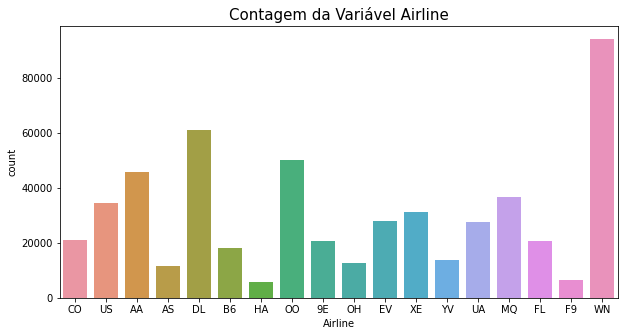

In [12]:
plt.figure(figsize = (10, 5))
ax = sns.countplot(data = base_airlines, x = base_airlines.Airline)
plt.title('Contagem da Variável Airline', fontsize= 15)
plt.show()

Nesse gráfico podemos ver claramente que uma empresa aerea faz muito mais voos que as demais.

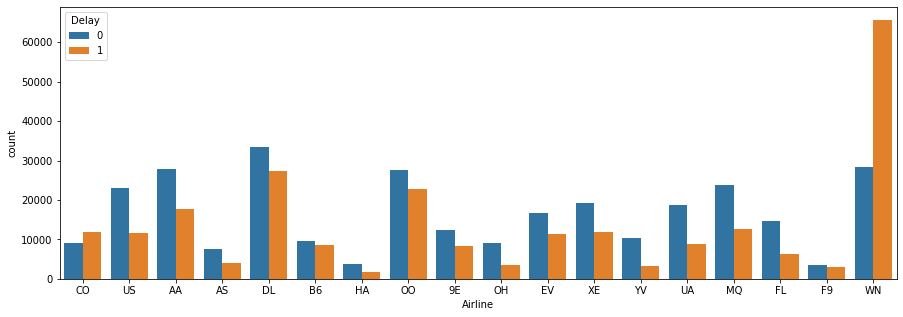

In [30]:
plt.figure(figsize = (15,5))
sns.countplot(x = 'Airline', hue= 'Delay', data = base_airlines)

Nesse gráfico temos uma informação importante, podemos ver que a empresa aerea WN tem um número muito grande de voos com atraso, isso poderia ser explicado pelo fato de a compania WN fazer muitos voos, mais ainda sim temos uma relação desproporcional entre os voos com atraso e sem atraso da propria compania WN. 


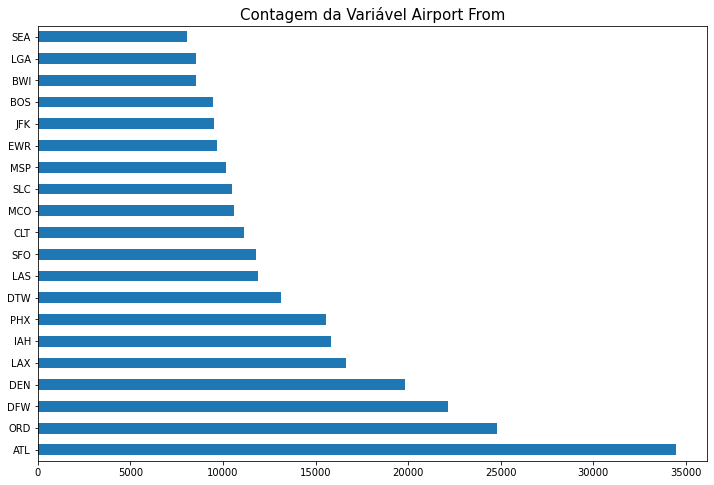

In [13]:
plt.figure(figsize = (12, 8))
base_airlines.AirportFrom.value_counts().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Contagem da Variável Airport From', fontsize= 15)
plt.show()

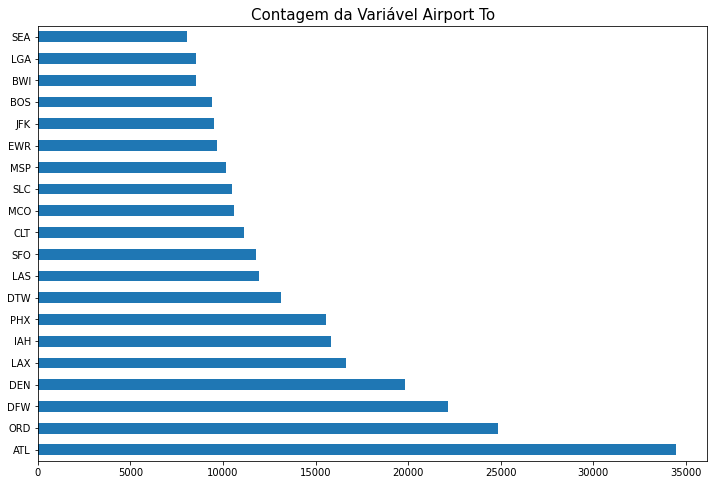

In [14]:
plt.figure(figsize = (12, 8))
base_airlines.AirportTo.value_counts().sort_values(ascending = False).head(20).plot(kind = 'barh')
plt.title('Contagem da Variável Airport To', fontsize= 15)
plt.show()

Os aeroportos de origem e de destino parecem ter um padrão onde os mesmos aeroportos concentram o maior número de saida de voos e de chegada, podemos dizer que isso se deve por conta de esses aeroportos terem uma movimentação maior

## Análise das Variáveis Númericas

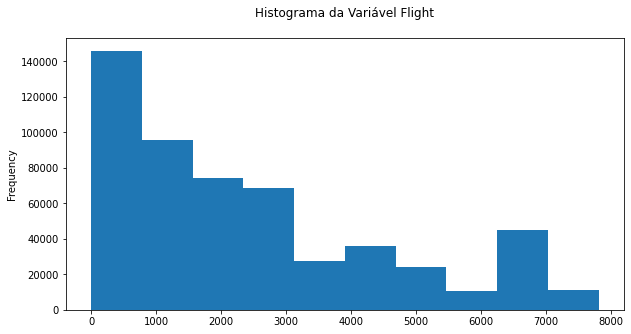

In [15]:
plt.figure(figsize = (10, 5))
base_airlines.Flight.plot(kind='hist') 
plt.title('Histograma da Variável Flight\n')
plt.show()

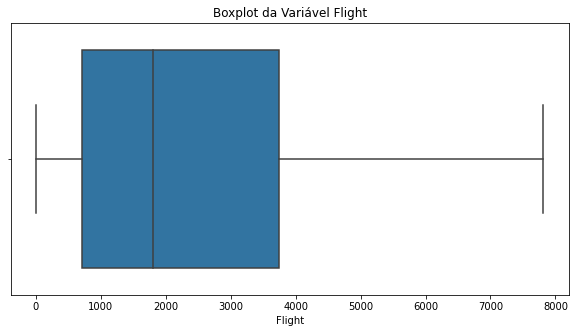

In [16]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = base_airlines.Flight)
plt.title('Boxplot da Variável Flight')
plt.show()

A variavel Flight se refere ao tipo de voo, e normal que ela não tenha um padrão que seja relevante

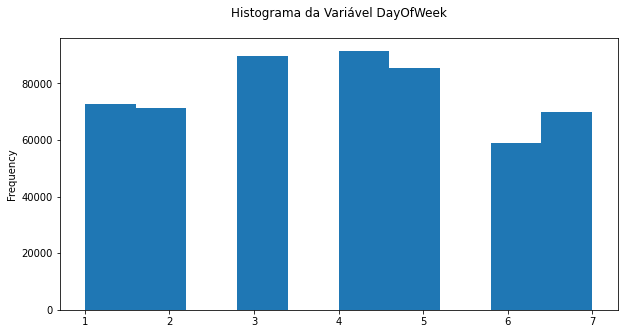

In [17]:
plt.figure(figsize = (10, 5))
base_airlines.DayOfWeek.plot(kind='hist') 
plt.title('Histograma da Variável DayOfWeek\n')
plt.show()

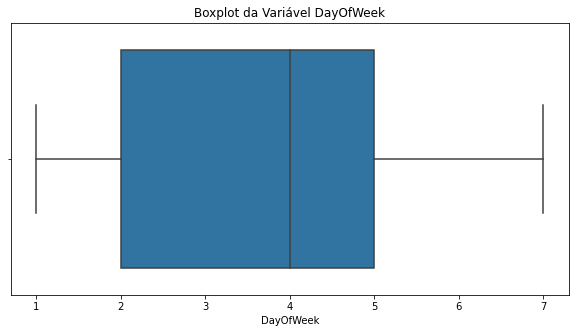

In [18]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = base_airlines.DayOfWeek)
plt.title('Boxplot da Variável DayOfWeek')
plt.show()

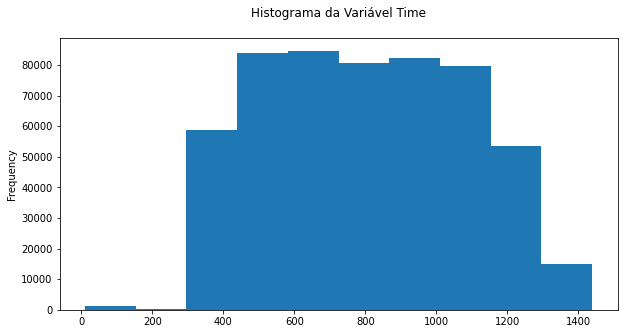

In [19]:
plt.figure(figsize = (10, 5))
base_airlines.Time.plot(kind='hist') 
plt.title('Histograma da Variável Time\n')
plt.show()

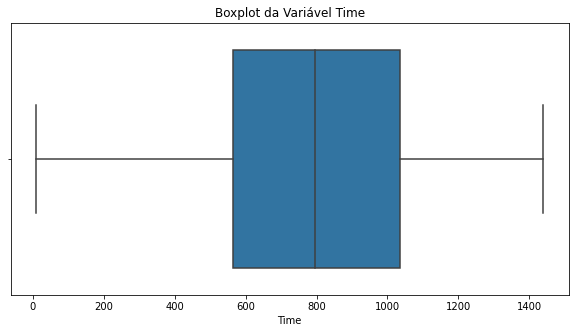

In [20]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = base_airlines.Time)
plt.title('Boxplot da Variável Time')
plt.show()

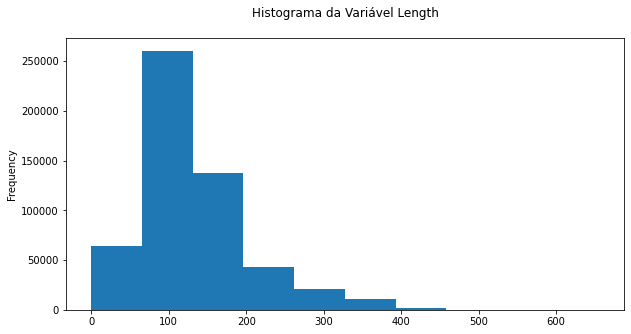

In [21]:
plt.figure(figsize = (10, 5))
base_airlines.Length.plot(kind='hist') 
plt.title('Histograma da Variável Length\n')
plt.show()

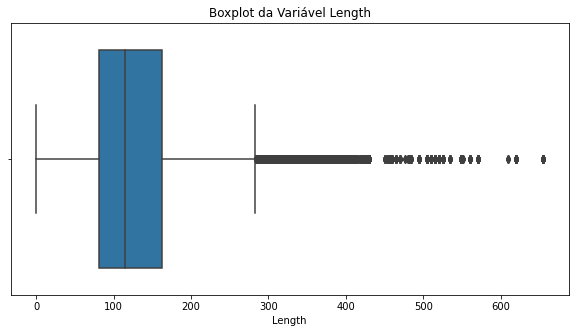

In [22]:
plt.figure(figsize = (10, 5))
sns.boxplot(x = base_airlines.Length)
plt.title('Boxplot da Variável Length')
plt.show()

 A variável Length representa a distancia do voo representada em Minutos, aqui podemos ver que temos alguns valores outliers, por enquanto vou deixar eles como estão, e mais para frente posso ver se a remoção deles é uma boa ideia.

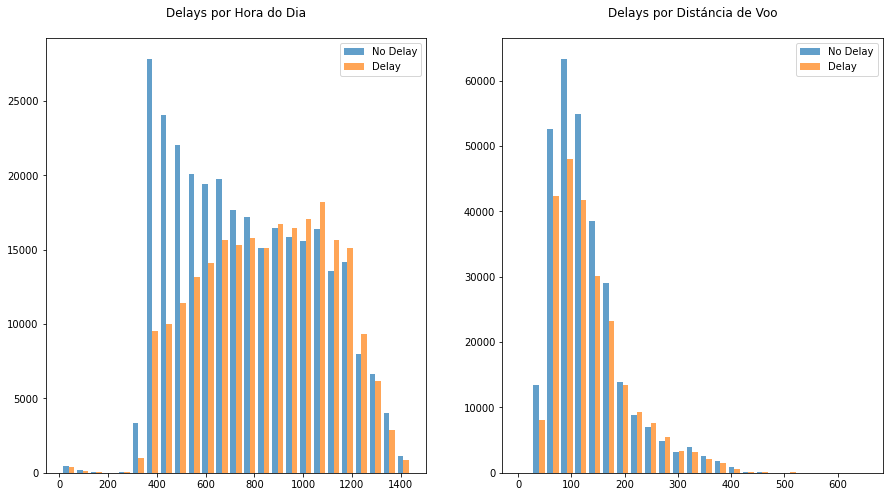

In [7]:
plt.figure(figsize= (15,8))
plt.subplot(1, 2, 1)

plt.hist([base_airlines.Time[base_airlines.Delay == 0], base_airlines.Time[base_airlines.Delay == 1]], 25, alpha = .7, histtype='bar', label=["No Delay","Delay"])
plt.title(f'Delays por Hora do Dia\n')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist([base_airlines.Length[base_airlines.Delay == 0], base_airlines.Length[base_airlines.Delay == 1]], 25, alpha = .7, histtype='bar', label=["No Delay","Delay"])
plt.title(f'Delays por Distáncia de Voo\n')
plt.legend()
  
plt.show()

Nesses dois gráficos podemos ver duas coisas.

- Primeiro que aparentemente pela parte da manham temos bem menos atrasos, o que nos diz que a variável Time tem alguma relação com o atraso.

- Segundo que apesar de termos um volume maior de voos mais curtos, não parece ter uma relação tão significativa entre e variável Length e os atrasos

Agora vamos calcular o percentual de voos com atraso e sem atraso para cada compania aerea para ter uma ideia de como esses dados estão distribuidos entre as companias aereas.

In [47]:
name_companys = base_airlines.Airline.value_counts().index.tolist()

list_perc_delay = []
list_perc_not_delay = []

for name in name_companys:

  base_delay = base_airlines.Delay.value_counts()
  company = base_airlines[base_airlines.Airline == name].Delay.value_counts()

  perc_delay = company[1] / base_delay[1] * 100 
  list_perc_delay.append(round(perc_delay, 2))

  perc_not_delay = company[0] / base_delay[0] * 100 
  list_perc_not_delay.append(round(perc_not_delay, 2))
  

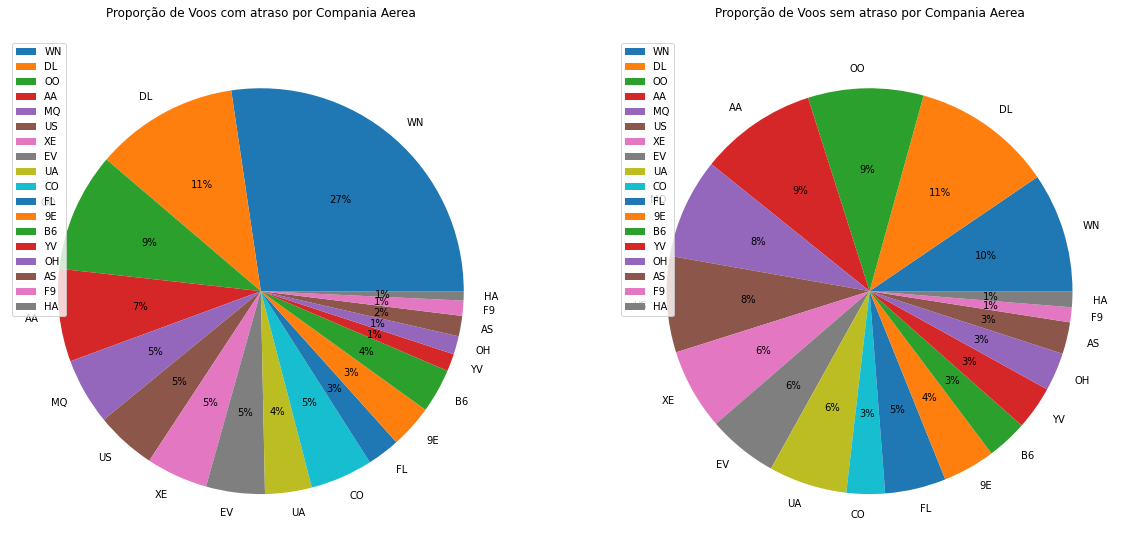

In [51]:
plt.figure(figsize= (20,15))
plt.subplot(1, 2, 1)

plt.pie(list_perc_delay, labels = name_companys, autopct='%.0f%%')
plt.title(f'Proporção de Voos com atraso por Compania Aerea\n')
plt.legend()

plt.subplot(1, 2, 2)
plt.pie(list_perc_not_delay, labels = name_companys, autopct='%.0f%%')
plt.title(f'Proporção de Voos sem atraso por Compania Aerea\n')
plt.legend()
  
plt.show()

Como podemos ver, quando estamos falando de voos com atraso, a compania WN tem um volume de voos com atraso bem maior que as outras chegando a ser maior do que as companias que tem os maiores percentuais juntas.

E quando falamos de voos sem atraso temos uma distribuição mais igual para as companias.

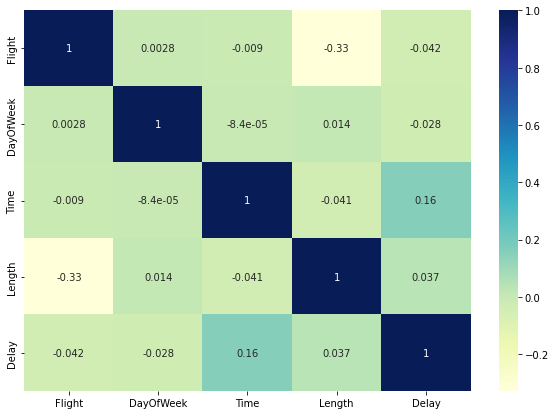

In [61]:
plt.figure(figsize=(10,7))
sns.heatmap(base_airlines.corr('spearman'), annot = True, cmap='YlGnBu')
plt.show()

podemos ver no grafico de correlação que apenas a variável Time tem alguma correlação com a nossa variável alvo Delay, enquanto as outras tem muito pouca relação

In [62]:
base_airlines.head()

,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,CO,269,SFO,IAH,3,15,205,1
1,US,1558,PHX,CLT,3,15,222,1
2,AA,2400,LAX,DFW,3,20,165,1
3,AA,2466,SFO,DFW,3,20,195,1
4,AS,108,ANC,SEA,3,30,202,0


Para ver a correlação entre as variáveis categoricas e a variável alvo vou usar.

Wight of Evidence (WOE) e Information Value (IV)

O WOE so vai e calculado aqui para chegar ao IV.

Para o Information Value, iremos analisar da seguinte forma.

- Menor 0.02, não deve ser usado para previsão
- 0.02 - 0.1, preditor fraco
- 0.1 - 0.3, preditor médio
- 0.3 - 0.5, preditor forte
- Maior 0.5, parece bom demais para ser verdade


In [63]:
for i in base_airlines.drop(columns= ['Flight', 'DayOfWeek', 'Time', 'Length', 'Delay'], axis = 1):

 df_woe_iv = (pd.crosstab(base_airlines[i], base_airlines['Delay'], normalize = 'columns')
 .assign(woe = lambda dfx: np.log(dfx[1] / dfx[0]))
 .assign(iv = lambda dfx: np.sum(dfx['woe'] * (dfx[1]-dfx[0])) )
 )
 print(df_woe_iv,'\n'+ '-'*50)


Delay           0         1       woe        iv
Airline                                        
9E       0.041656  0.034237 -0.196120  0.298589
AA       0.093341  0.073819 -0.234644  0.298589
AS       0.025338  0.016199 -0.447355  0.298589
B6       0.032271  0.035207  0.087065  0.298589
CO       0.030627  0.049766  0.485465  0.298589
DL       0.111955  0.114258  0.020355  0.298589
EV       0.055924  0.046844 -0.177168  0.298589
F9       0.011892  0.012066  0.014552  0.298589
FL       0.048650  0.026117 -0.622052  0.298589
HA       0.012677  0.007433 -0.533812  0.298589
MQ       0.079778  0.053033 -0.408322  0.298589
OH       0.030516  0.014576 -0.738909  0.298589
OO       0.091917  0.094729  0.030140  0.298589
UA       0.062427  0.037234 -0.516769  0.298589
US       0.076588  0.048243 -0.462198  0.298589
WN       0.095079  0.273270  1.055751  0.298589
XE       0.064626  0.049092 -0.274931  0.298589
YV       0.034739  0.013876 -0.917664  0.298589 
---------------------------------------

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Como podemos ver no resultado, temos a variável Airlines e AirportFrom com uma boa correlação com a nossa variável alvo, já a variável AirportTo sem nenhuma relação com a nossa variável alvo.

Como podemos ver mais acima, a variável Length tem outliers, antes de prosseguir vou tratar esses outliers e refazer o teste do coeficiente de correlação para ver se temos alguma mudança

In [11]:
min = base_airlines.Length.min()
Q1 = base_airlines.Length.quantile(0.25)
median = base_airlines.Length.quantile(0.5)
Q3 = base_airlines.Length.quantile(0.75)
max = base_airlines.Length.max()
IQR = Q3 - Q1

cut_off = IQR * 1.5

temp_df = (base_airlines.Length < (Q1 - cut_off)) | (base_airlines.Length > (Q3 + cut_off))

print(temp_df.value_counts(normalize = True)*100)

False    95.244566
True      4.755434
Name: Length, dtype: float64


Temos 4% de outliers nessa variável, não e um grande valor com relação ao tamanho da base de dados, mais ainda sim nesse caso vou optar por não remover os outliers, vou trata-los mudando seus valores para os valores do limite maximo ou minimo

In [12]:
base_airlines_cleaned = base_airlines.copy()
lower, upper = Q1 - cut_off, Q3 + cut_off

base_airlines_cleaned.Length = np.where(base_airlines_cleaned.Length > upper, upper, base_airlines_cleaned.Length)
base_airlines_cleaned.Length = np.where(base_airlines_cleaned.Length < lower, lower, base_airlines_cleaned.Length)

In [14]:
temp_df = (base_airlines_cleaned.Length < (Q1 - cut_off)) | (base_airlines_cleaned.Length > (Q3 + cut_off))

print(temp_df.value_counts(normalize = True)*100)

False    100.0
Name: Length, dtype: float64


Pronto não temos mais nenhum outlier na variável Length

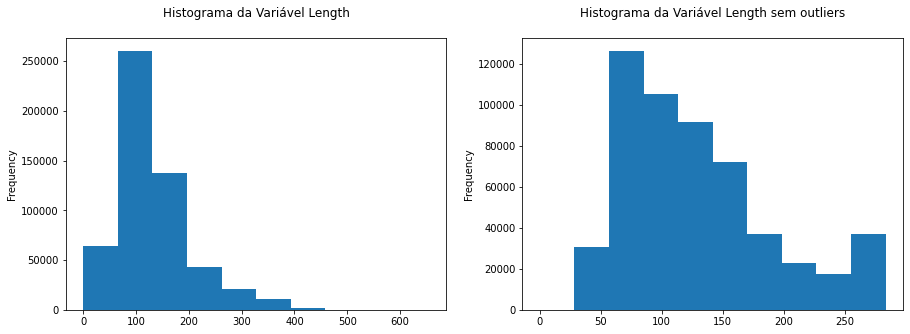

In [19]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
base_airlines.Length.plot(kind='hist') 
plt.title('Histograma da Variável Length\n')
plt.subplot(122)
base_airlines_cleaned.Length.plot(kind='hist') 
plt.title('Histograma da Variável Length sem outliers\n')
plt.show()

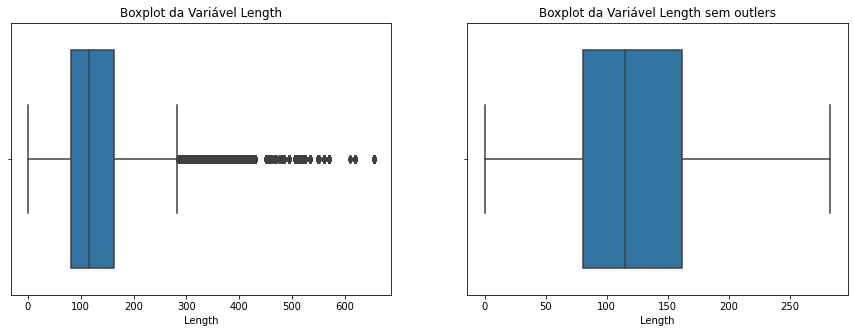

In [21]:
plt.figure(figsize = (15, 5))
plt.subplot(121)
sns.boxplot(x = base_airlines.Length)
plt.title('Boxplot da Variável Length')
plt.subplot(122)
sns.boxplot(x = base_airlines_cleaned.Length)
plt.title('Boxplot da Variável Length sem outlers')
plt.show()

Podemos ver algumas mudanças na distribuição dos dados da variável Length, principalmente no histograma

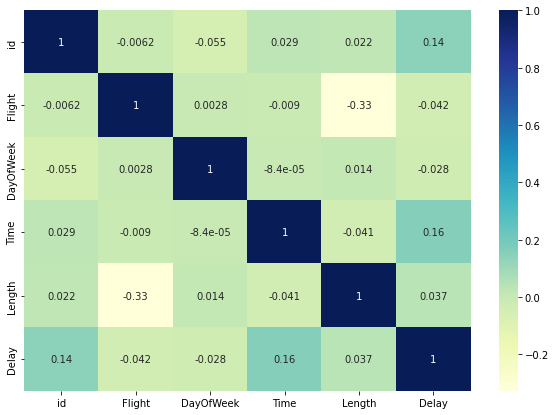

In [22]:
plt.figure(figsize=(10,7))
sns.heatmap(base_airlines_cleaned.corr('spearman'), annot = True, cmap='YlGnBu')
plt.show()

Não tivemos nenhuma mudança na correlação, como podemos ver aqui depois de analisar as correlações as variáveis (Length , DayOfWeek, Flight, AirportTo) tem baixa ou nenhuma correlação com a nossa variavel alvo.

Então o que vou fazer e remove-las e seguir com o modelo sem elas.

In [23]:
base_airlines_cleaned = base_airlines_cleaned.drop(columns= ['Length' , 'DayOfWeek', 'Flight', 'AirportTo'], axis = 1)

In [24]:
base_airlines_cleaned.head()

,Airline,AirportFrom,Time,Delay
0,CO,SFO,15,1
1,US,PHX,15,1
2,AA,LAX,20,1
3,AA,SFO,20,1
4,AS,ANC,30,0


In [25]:
base_airlines_encoded = base_airlines_cleaned.copy()
le = preprocessing.LabelEncoder()

base_airlines_encoded['Airline'] = le.fit_transform(base_airlines_encoded['Airline'])
base_airlines_encoded['AirportFrom'] = le.fit_transform(base_airlines_encoded['AirportFrom'])

display(base_airlines_encoded)

,Airline,AirportFrom,Time,Delay
0,4,253,15,1
1,14,217,15,1
2,1,154,20,1
3,1,253,20,1
4,2,14,30,0
...,...,...,...,...
539378,4,203,1439,0
539379,8,252,1439,0
539380,8,253,1439,0
539381,13,128,1439,1


In [26]:
y = base_airlines_encoded['Delay']
X = base_airlines_encoded.drop('Delay', axis = 1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=True)

In [27]:
DecisionTreeClassifierModel = DecisionTreeClassifier(criterion='entropy',max_depth=16,random_state=40)
DecisionTreeClassifierModel.fit(X_train, y_train)

print('DecisionTreeClassifierModel Train Score is : ' , DecisionTreeClassifierModel.score(X_train, y_train))
print('DecisionTreeClassifierModel Test Score is : ' , DecisionTreeClassifierModel.score(X_test, y_test))

DecisionTreeClassifierModel Train Score is :  0.6743599673700778
DecisionTreeClassifierModel Test Score is :  0.6567047961586236


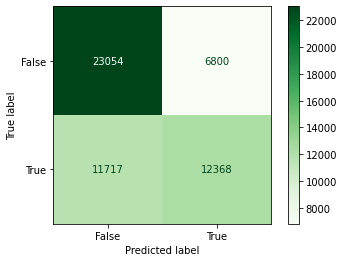

In [28]:
yPredDecisionTree = DecisionTreeClassifierModel.predict(X_test)

confusionMatrixDecisionTree = confusion_matrix(y_test, yPredDecisionTree)

confusionMatrixDecisionTree_display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrixDecisionTree, display_labels = [False, True])
confusionMatrixDecisionTree_display.plot(cmap='Greens')
plt.show()

In [29]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'entropy', max_depth=18, n_estimators=400, random_state=44)
RandomForestClassifierModel.fit(X_train, y_train)

print('RandomForestClassifierModel Train Score is : ' , RandomForestClassifierModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RandomForestClassifierModel.score(X_test, y_test))

RandomForestClassifierModel Train Score is :  0.6923723436688887
RandomForestClassifierModel Test Score is :  0.666716105229982


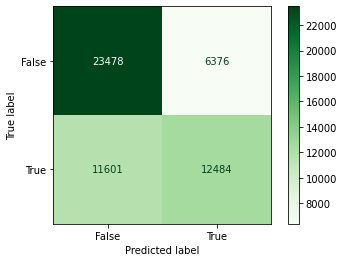

In [30]:
yPredRandomForest = RandomForestClassifierModel.predict(X_test)

confusionMatrixRandomForest = confusion_matrix(y_test, yPredRandomForest)

confusionMatrixRandomForest_display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrixRandomForest, display_labels = [False, True])
confusionMatrixRandomForest_display.plot(cmap='Greens')
plt.show()

In [31]:
GradientBoostingClassifierModel = GradientBoostingClassifier(n_estimators=300, max_depth=8, learning_rate=0.25, random_state=44)
GradientBoostingClassifierModel.fit(X_train, y_train)
print('GBCModel Train Score is : ' , GradientBoostingClassifierModel.score(X_train, y_train))
print('GBCModel Test Score is : ' , GradientBoostingClassifierModel.score(X_test, y_test))

GBCModel Train Score is :  0.690501891052315
GBCModel Test Score is :  0.6646582250319806


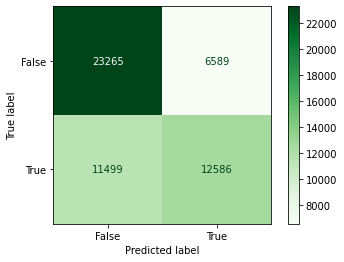

In [32]:
yPredGradientBoostingClassifier = GradientBoostingClassifierModel.predict(X_test)

confusionMatrixBoostingClassifier = confusion_matrix(y_test, yPredGradientBoostingClassifier)

confusionMatrixBoostingClassifier_display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrixBoostingClassifier, display_labels = [False, True])
confusionMatrixBoostingClassifier_display.plot(cmap='Greens')
plt.show()

In [33]:
VotingClassifierModel = VotingClassifier(estimators=[('GBCModel',GradientBoostingClassifierModel),
                                                     ('RFCModel',RandomForestClassifierModel),
                                                     ('TDCModel',DecisionTreeClassifierModel)],
                                         voting='hard')
VotingClassifierModel.fit(X_train, y_train)
print('VotingClassifierModel Train Score is : ' , VotingClassifierModel.score(X_train, y_train))
print('VotingClassifierModel Test Score is : ' , VotingClassifierModel.score(X_test, y_test))

VotingClassifierModel Train Score is :  0.6905369105396297
VotingClassifierModel Test Score is :  0.6663082370826304


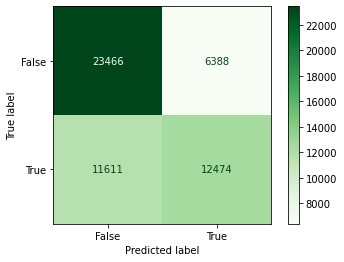

In [34]:
yPredVotingClassifierModel = VotingClassifierModel.predict(X_test)

confusionMatrixVotingClassifierModel = confusion_matrix(y_test, yPredVotingClassifierModel)

confusionMatrixVotingClassifierModel_display = ConfusionMatrixDisplay(confusion_matrix = confusionMatrixVotingClassifierModel, display_labels = [False, True])
confusionMatrixVotingClassifierModel_display.plot(cmap='Greens')
plt.show()

Testado com 3 modelos (KNN,Decision Tree,Random Forest), mas nenhum deles deu uma boa acuracia. Apesar de termos alguma correlação entre os horarios dos voos e das Companias Aereas, isso não foi o suficiente para treinar um bom modelo.

As informações disponiveis no dataset não parecem ser suficientes para treinar um bom modelo, uma solução seria adicionar mais informações ao dataset para ter mais dados que possamos analisar e usar em nosso modelo

Podemos ver algumas informações importantes como algumas Companias aereas que fazem mais voos que outras, e algumas com mais atrasos que outras sendo que uma delas se destaca a "Compania WN" que detem o maior número de voos e quase 25% dos atrasos correspondem a ela, contudo mesmo com esse valor ainda temos no total quase os mesmos números de voos com atrasos e voos sem atrasos.